In [1]:
from insight_analyzer import PredictionAnalyzer

# notebook input from an insight
sample = PredictionAnalyzer(insight_id="657f0cc8-fa05-46bb-9808-8cf4f065ce3d")

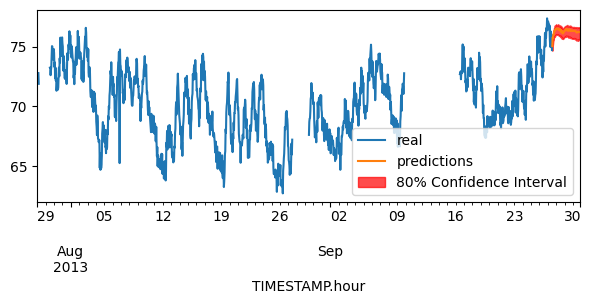

In [2]:
result = sample.predict(steps=80, conf_interval=80)

In [3]:
print(result)

{"attribute": ["2013-07-28 00:00:00", "2013-07-28 01:00:00", "2013-07-28 02:00:00", "2013-07-28 03:00:00", "2013-07-28 04:00:00", "2013-07-28 05:00:00", "2013-07-28 06:00:00", "2013-07-28 07:00:00", "2013-07-28 08:00:00", "2013-07-28 09:00:00", "2013-07-28 10:00:00", "2013-07-28 11:00:00", "2013-07-28 12:00:00", "2013-07-28 13:00:00", "2013-07-28 14:00:00", "2013-07-28 15:00:00", "2013-07-28 16:00:00", "2013-07-28 17:00:00", "2013-07-28 18:00:00", "2013-07-28 19:00:00", "2013-07-28 20:00:00", "2013-07-28 21:00:00", "2013-07-28 22:00:00", "2013-07-28 23:00:00", "2013-07-29 00:00:00", "2013-07-29 01:00:00", "2013-07-29 02:00:00", "2013-07-29 03:00:00", "2013-07-29 04:00:00", "2013-07-29 05:00:00", "2013-07-29 06:00:00", "2013-07-29 07:00:00", "2013-07-29 08:00:00", "2013-07-29 09:00:00", "2013-07-29 10:00:00", "2013-07-29 11:00:00", "2013-07-29 12:00:00", "2013-07-29 13:00:00", "2013-07-29 14:00:00", "2013-07-29 15:00:00", "2013-07-29 16:00:00", "2013-07-29 17:00:00", "2013-07-29 18:00:0